In [ ]:
# 참고
# https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/examples/digit_classifier/ml/mnist_tflite.ipynb

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

This notebook shows an end-to-end example of training a TensorFlow model using Keras and Python, then export it to TensorFlow and TensorFlow Lite format. Here we will train a handwritten digit classifier using MNIST dataset.


## Enabling the Tensorflow with GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
!pip install tensorflow-gpu

In [ ]:
# tensorflow 2.X 대 버전을 불러온다.
%tensorflow_version 2.x
import tensorflow as tf
# 접속되어 있는 VM 이 GPU 를 사용하고 있는지 확인합니다. 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.2.0


## Setup

In [ ]:
# 필요로 하는 패키지와 모듈을 불러옵니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math

# 상수 정의
batch_size = 128    # batch size
num_classes = 10    # 분류 클래스 종류(0 ~ 9)
epochs = 100        # training 횟수

# 25개의 샘플 이미지를 Display 해 주는 함수 정의
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

# 특정한 숫자(Digit)만 25개 Display 해 주는 함수 정의 
def show_sample_digit(images, labels, digit, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  i = 0
  digit_count = 0
  while digit_count < sample_count:
    i += 1
    if (digit == labels[i]):
      plt.subplot(grid_count, grid_count, digit_count+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.gray)
      plt.xlabel(labels[i])
      digit_count += 1
  plt.show()

# 특정한 숫자(digit)의 이미지와 예측한 label 을 Display 해주는 함수 정의
def show_digit_image(image):
  # Draw digit image
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  # Major ticks every 20, minor ticks every 5
  major_ticks = np.arange(0, 29, 5)
  minor_ticks = np.arange(0, 29, 1)
  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)
  # And a corresponding grid
  ax.grid(which='both')
  # Or if you want different settings for the grids:
  ax.grid(which='minor', alpha=0.2)
  ax.grid(which='major', alpha=0.5)
  ax.imshow(image, cmap=plt.cm.binary)

  plt.show()

## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to demonstrate how to train a image classification model

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit.
![MNIST sample](https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/mnist.png)

In [ ]:
# Keras에 있는 MNIST dataset을 다운로드 받습니다.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0    # 픽셀 값을 0~1 범위로 변환     
test_images = test_images / 255.0      # 픽셀 값을 0~1 범위로 변환

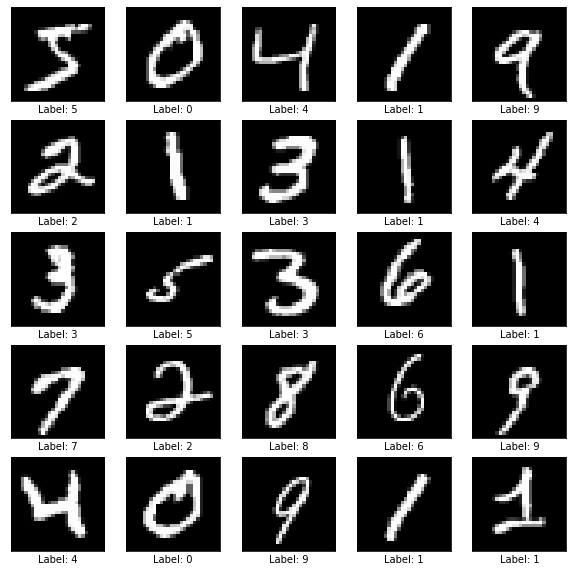

In [ ]:
# training dataset 에서 25개의 샘플 이미지를 Display 해 줍니다.
show_sample(train_images, 
            ['Label: %s' % label for label in train_labels])

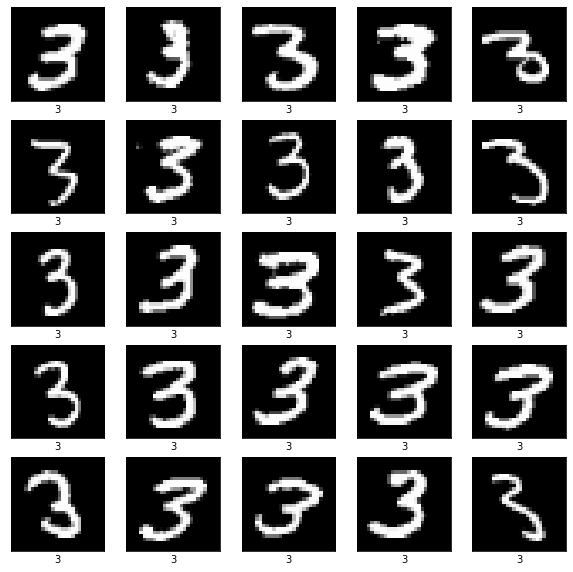

In [ ]:
# training dataset에서 특정한 숫자(Digit)만 25개 Display 해 줍니다. 
show_sample_digit(train_images, train_labels, 3)

## Train a TensorFlow model to classify digit images
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/beta/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [ ]:
# create model(모델을 만듭니다)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),

    # keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint('digits_model.h5', save_best_only=True)

# 모델 학습시 loss값을 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
#monitorEarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# model training(모델을 학습시킵니다)
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=epochs, batch_size=batch_size,
                    #callbacks=[monitorEarlyStop,modelCheckpoint])
                    callbacks=[modelCheckpoint])

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2523 - accuracy: 0.9239 - val_loss: 0.0622 - val_accuracy: 0.9802
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0913 - accuracy: 0.9726 - val_loss: 0.0393 - val_accuracy: 0.9867
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0655 - accuracy: 0.9802 - val_loss: 0.0355 - val_accuracy: 0.9888
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0522 - accuracy: 0.9842 - val_loss: 0.0326 - val_accuracy: 0.9889
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 0.0294 - val_accuracy: 0.9904
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0404 - accuracy: 0.9876 - val_loss: 0.0328 - val_accuracy: 0.9890
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0286 - val_accuracy: 0.9916

## Evaluate our model
We run our digit classification model against our test dataset that the model hasn't seen during its training process. We want to confirm that the model didn't just remember the digits it saw but also generalize well to new images.

313/313 [==============================] - 1s 2ms/step - loss: 0.0462 - accuracy: 0.9934
Test accuracy: 0.993399977684021


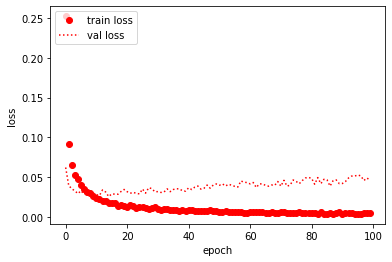

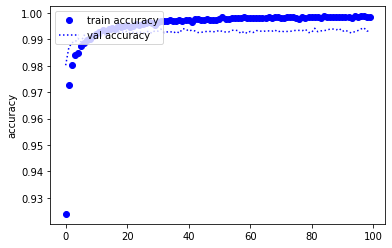

In [ ]:
# model evaluate(모델을 평가해 봅니다)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

# 모델 학습시 history 객체 저장해 두었던 loss Value, accuracy 정보를 그래프로 표현해 봅니다.
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
fig, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label='train loss')     # train loss
loss_ax.plot(history.history['val_loss'], 'r:', label='val loss')   # validation loss
loss_ax.set_xlabel('epoch')     # x축 label은 epoch   
loss_ax.set_ylabel('loss')      # y축 label은 loss
loss_ax.legend(loc='upper left')  # 범례의 위치는 왼쪽 위

acc_ax.plot(history.history['accuracy'], 'bo', label='train accuracy')   # tain accuracy
acc_ax.plot(history.history['val_accuracy'], 'b:', label='val accuracy') # validation accuracy
acc_ax.set_ylabel('accuracy')  # y축 label은 accuracy
acc_ax.legend(loc='upper left')  # 범례의 위치는 왼쪽 위

plt.show()

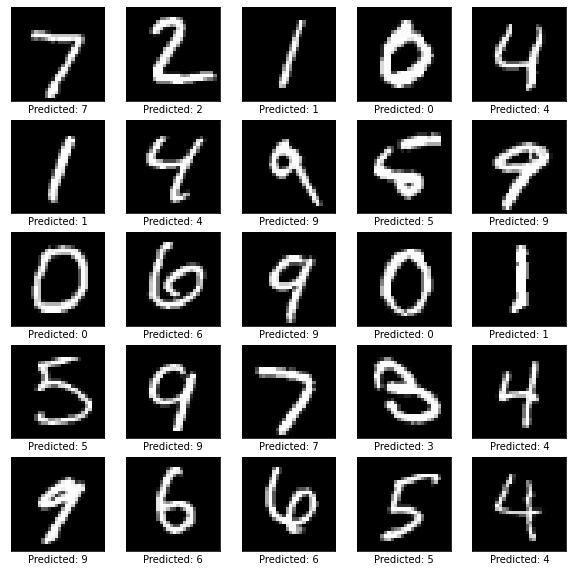

In [ ]:
# test dataset을 우리가 만든 모델을 통해 digit label을 예측합니다.
predictions = model.predict(test_images)

# 예측한 결과를 Display 합니다.
show_sample(test_images, 
            ['Predicted: %d' % np.argmax(result) for result in predictions])

Number is  7


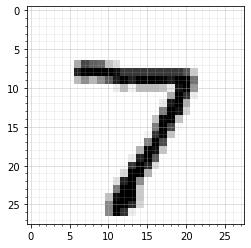

In [ ]:
# 예측 결과 중에서 특정한 숫자(digit)의 이미지와 예측한 label 을 Display 합니다.
selected_digit = 0

result = predictions[selected_digit]
result_number = np.argmax(result)
print('Number is %2i' % (result_number))

show_digit_image(test_images[selected_digit])